In [63]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank
from scipy.sparse import csr_matrix

In [64]:
# updated function -- verified 12/27/2023

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

# Create Graph using Bipartite Projection on Arxiv Dataset

In [65]:
data = r'data\arxiv_artificial_life.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Kiarash Sedghighadikolaei,A Comprehensive Survey of Threshold Digital Si...
1,Attila Altay Yavuz,A Comprehensive Survey of Threshold Digital Si...
2,Alenka {Č}opi{č},Phosphatidylserine transport in cell life and ...
3,Thibaud Dieudonné,Phosphatidylserine transport in cell life and ...
4,Guillaume Lenoir,Phosphatidylserine transport in cell life and ...


In [66]:
len(set(df['title']))

19989

In [67]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [68]:
#print(nx.info(G)) # deprecated

print(G)

Graph with 48753 nodes and 273061 edges


# Community Detection + Community Analysis

There's two parts to what I am attempting today.
- I need to use community detection to identify communities in the network.
- I can then use network science and data science to identify interesting communities

By interesting, I mean not stars. I am looking for complex ecosystems. So, I will identify communities, then attempt to detect more complex ecosystems by using triangles and density.

In this notebook, I am experimenting with a python library for interactive visualization. 

## Community Detection

In [69]:
#! pip install python-louvain --user

In [70]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=0.01, random_state=1337) # 10 was good for this network

In [71]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

community_df['community'].value_counts()[0:20]

community
10653    237
1770     193
993      165
9576     163
3939     122
4791     109
10966    104
7718      94
10344     88
5148      86
4156      81
5323      78
8777      74
3741      68
3827      67
9316      67
217       65
624       59
4461      55
10968     54
Name: count, dtype: int64

In [72]:
community_node_counts = community_df['community'].value_counts()

community_size_df = pd.DataFrame(community_node_counts).reset_index()
community_size_df.columns = ['community', 'node_count']

# just to speed up this experiment
community_size_df = community_size_df[community_size_df['node_count'] > 10]

community_size_df.head()

,community,node_count
0,10653,237
1,1770,193
2,993,165
3,9576,163
4,3939,122


In [73]:
community_size_df.shape

(418, 2)

## Capture Community Context

In [74]:
def get_community_nodes(community_df, community):

    return sorted(community_df[community_df['community']==community]['node'].values)

In [75]:
def get_community_context(community_size_df, community_df, G):

    G = G.copy()

    communities = {}

    for row in community_size_df.iterrows():

        data = row[1]
        community = data['community']
        node_count = data['node_count']
        
        nodes = get_community_nodes(community_df, community)
        G_sub = G.subgraph(nodes)

        # starting with density today; will add on more context later
        density = nx.density(G_sub)
        
        communities[community] = {}

        communities[community]['G'] = G_sub
        communities[community]['density'] = density
        communities[community]['node_count'] = len(G_sub.nodes)
        
    return communities

In [76]:
community_df.head()

,node,community
0,Alenka {Č}opi{č},0
1,Thibaud Dieudonné,0
2,Guillaume Lenoir,0
3,Michele Ambrosino,4
4,Manar Mahmalji,4


In [77]:
community_size_df.head(1)

,community,node_count
0,10653,237


In [78]:
community_context_dict = get_community_context(community_size_df, community_df, G)

In [79]:
community_context_df = pd.DataFrame(community_context_dict).T.reset_index()
community_context_df.columns = ['community', 'G', 'density', 'node_count']

# drop dense
community_context_df = community_context_df[community_context_df['density']<0.6]

community_context_df.head(20)

,community,G,density,node_count
0,10653,"(P. Gorla, G. Pettinari, C. Rosenfeld, M. Chap...",0.552242,237
1,1770,"(B. Lehnert, GERDA Collaboration, E. Andreotti...",0.585816,193
24,7787,"(Jeffrey S. Pigott, Renyu Hu, Lars P. Stixrude...",0.424947,44
45,1312,"(R. S. Boiko, R. B. Podviyanuk, I. A. Tupitsyn...",0.473118,31
49,2019,"(J. Debus, E. A. Chekhovich, T. Godde, D. N. K...",0.514778,29
99,3363,"(E. Wagner, B. Canals, F. Montaigne, S. Le Den...",0.452381,21
101,6766,"(Saurabh Singh, Thippa Reddy Gadekallu, Navod ...",0.433333,21
109,6690,"(Jiayuan Mao, Andrei Barbu, Aviv Netanyahu, El...",0.352381,21
110,5583,"(J. C. Hardy, H. I. Park, C. A. Gagliardi, X. ...",0.557143,21
113,5150,"(A. N. Shubin, F. F. Karpeshin, S. I. Panasenk...",0.561905,21


#### Investigate Communities

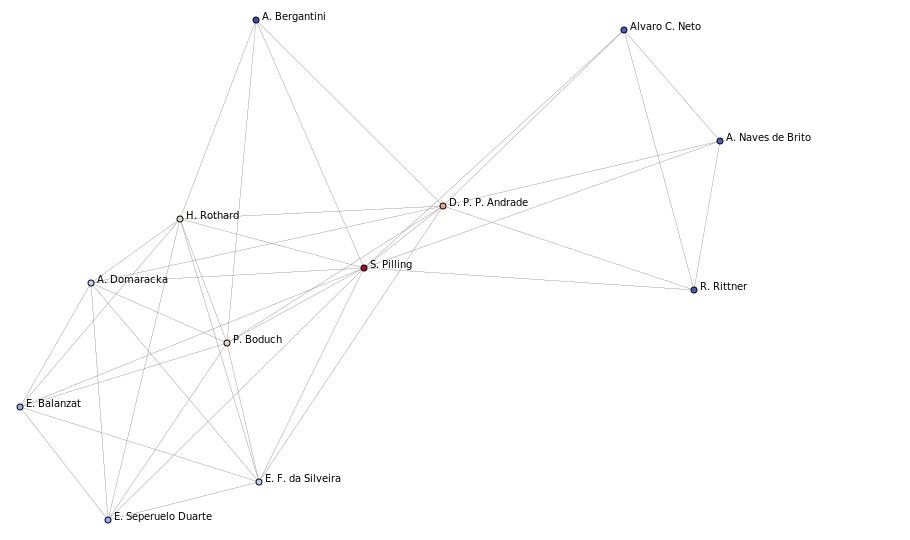

In [80]:
G_check = community_context_dict[3996]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

# Interactive Exploration

I'll use G_check graph with libraries for interactive exploration.

So far, not worth the effort of getting it to open in the notebook directly. I get this error. Will open in a tab instead.

Error:
'charmap' codec can't encode characters in position 263607-263621: character maps to <undefined>

In [81]:
#!pip install pyvis --upgrade --user

In [82]:
from pyvis.network import Network

In [83]:
# point to the full path or else jupyter might fail to open it even outside of jupyter; edge will try and fail
pyvis_file = r'C:/Users/itsgo/PythonCode/100daysofnetworks/pyvis/arxiv_community.html' 

# flip between communities to explore
#G_check = community_context_dict[communities[3]]['G']

net = Network(height='900px') # tweak for your browser; can also do width
net.from_nx(G_check)
# net.show_buttons() # gives you additional buttons at the bottom
net.show(pyvis_file, notebook=False) # can't get notebook=True to work yet...

C:/Users/itsgo/PythonCode/100daysofnetworks/pyvis/arxiv_community.html


# Interactive Exploration - Graphistry

The original dataframe won't be useful as an input dataframe for graphistry, as we had a step for bipartite projection. The first thing we need to do is convert our projected graph back into an edgelist, and we'll use that edgelist with graphistry.

https://github.com/graphistry/pygraphistry

In [85]:
#! pip install --user graphistry[bolt,gremlin,nodexl,igraph,networkx]

In [97]:
import graphistry

In [98]:
# Authenticate

cred_file = '../api_creds/graphistry.csv'

cred_df = pd.read_csv(cred_file)

personal_key_id = cred_df['personal_key_id'].values[0]
personal_key_secret = cred_df['personal_key_secret'].values[0]

graphistry.register(api=3, personal_key_id=personal_key_id, personal_key_secret=personal_key_secret)

In [100]:
# Convert Graph to Edgelist

net_df = nx.to_pandas_edgelist(G)
net_df.head()

,source,target
0,Alenka {Č}opi{č},Thibaud Dieudonné
1,Alenka {Č}opi{č},Guillaume Lenoir
2,Thibaud Dieudonné,Guillaume Lenoir
3,Michele Ambrosino,Emanuele Garone
4,Michele Ambrosino,Manar Mahmalji


In [101]:
# Visualize the Graph
g = graphistry.edges(net_df, source='source', destination='target')
g.plot()

# Conclusion

Pyvis is nice to look at and interactive, and if you use .show_buttons() then you get a lot of flexibility for colors, edge widths, etc. HOWEVER, and this is a big however, pyvis seems to only scale to a couple dozen nodes, which makes it about useless for working with real-world networks. It took five minutes to render just over a hundred nodes, where the scikit-network approach will do that in less than two seconds. This notebook is complete. 